# PyTorch Workflow

Example PyTorch end-to-end workflow.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
device = "cpu" if torch.cuda.is_available() else "cpu" # change first cpu to cuda, to use gpu

## For creating gifs:

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)
    

## 1. Data (preparing and loading)

Example using a linear regression formula with *known* **parameters**

In [3]:
# Create *known parameters
weight = 0.7
bias = 0.3

# Create range of numbers

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X+bias
X= X.to(device)
y = y.to(device)

X[:10], y[:10], len(X),len(y)




(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets

Create test and training set from data

In [4]:
# Create a train/test split
train_split = int(0.8*len(X))

X_train,y_train, X_test, y_test = torch.tensor(1, device=device), torch.tensor(1, device=device), torch.tensor(1, device=device), torch.tensor(1, device=device)

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]


In [5]:
files = []
model_0 = 0;
# Make function to visualize the data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    
    
    train_data = train_data.to("cpu")
    train_labels = train_labels.to("cpu")
    test_data = test_data.to("cpu")
    test_labels = test_labels.to("cpu")
    if predictions is not None:
        predictions = predictions.to("cpu")
    
    #Plots Training data, test data and compares predictions.
    
    plt.figure(figsize=(10,7))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=5, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=5, label="Testing data")
    
    # Are there predictions?
    
    if predictions is not None:
        #Plot them
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # Show the legend
    plt.legend(prop={"size": 14})



    
def MakeGIF(epoch = 0, epochs = 0):
    # plot the result as training progresses
    if (epoch+1) % 10 == 0: 
        with torch.inference_mode():
            y_preds_new = model_0(X_test)
        plot_predictions(predictions=y_preds_new)
        i=epoch
        file = "plots/nn_%i.png"%(epoch+1)
        plt.text(1.055,0.7,"Training step: %i"%(i+1),fontsize="x-large",color="k")
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (epoch+1) % 1000 == 0: plt.show()
        else: plt.close("all")
    

    



## 2. Build model

In [6]:
# Create liner regression model class

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                                requires_grad=True,
                                                device=device,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             device=device,
                                             dtype=torch.float))
        
    #Forward method to define the computation in the model
        
    def forward(self, x: torch.Tensor) -> torch.Tensor: #<- "x" is the input data
        return self.weights * x + self.bias
        
        
        


### PyTorch model building essentials

* torch.nn - contains all of the building blocks for nn
* torch.nn.Paramter - what paramters should our model try to learn.
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch are, they help with gradient descent.
* def forward() - All nn.Module subclasses require you to overwrite forward() (Forward propagation)

### Checking the contents of our PyTorch model

Check what is inside the model now

In [7]:
# Create a random seed

torch.manual_seed(42)

# Create an instance of the model

model_0 = LinearRegressionModel()

#Check the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check the models predictive power, check how well it predicts `y_test` based on `X_test`

In [9]:
# Make preditions with model
y_preds = torch.tensor(1, device=device)
y_preds.device
with torch.inference_mode():
    y_preds = model_0(X_test)



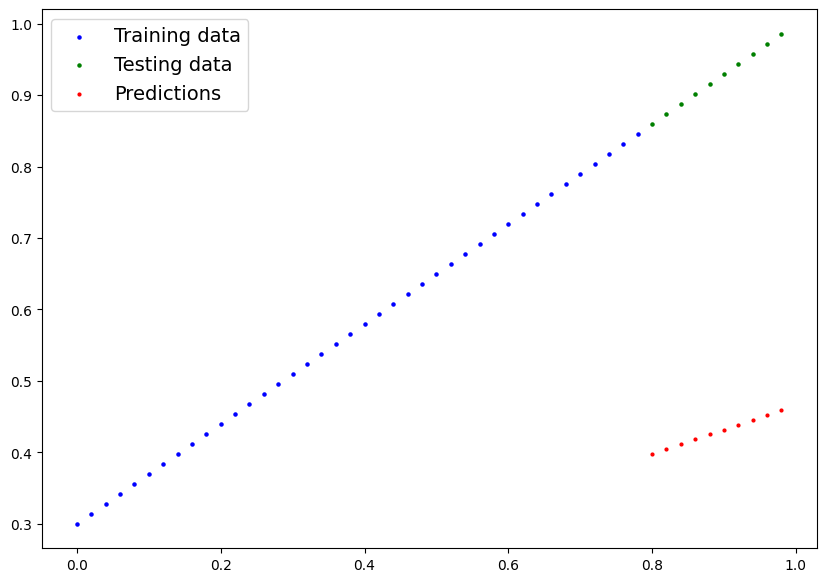

In [10]:
plot_predictions(predictions=y_preds)

## 3. Train model


In [11]:
# Setup a loss function (L1Loss = MAE (Mean absolute error))
loss_fn = nn.L1Loss()


# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), #Steepest gradient descent or stochastic gradient descent
                            lr=0.01) # learning rate

### Building a training loop in PyTorch

In [12]:
# Printout function

def printout(epoch = 0,loss = 0):
    #save_gif_PIL("nn.gif", files, fps=10, loop=0)
    with torch.inference_mode():
        y_preds_new = model_0(X_test)
    #plot_predictions(predictions=y_preds_new)
    print(f"Epochs: {epoch}")
    print(f"Loss: {loss}")
    print(f"Weights: {weight}, Bias: {bias}")
    print(f"{model_0.state_dict()}")

In [13]:
torch.manual_seed(42)
# An epoch is how many loops we want

epoch_count = []
loss_values = []
test_loss_values = []
epoch = 0
maxEpochs = 200
loss = 10000
### Training
# step 0. Loop trough the data
for epoch in range(maxEpochs):
#while loss > 0.0005:
    #epoch += 1
    # Set the model to training mode
    model_0.train() #train mode in PyTorch sets all parameters that requires gradients to require gradients
    
    # 1. Forward propagation
    y_pred = model_0(X_train)
     
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    #3. Optimizer zero grad
    
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()
    
### Testing
    model_0.eval() #turns off gradient tracking
    
    with torch.inference_mode(): #turns off gradient tracking
        #1. Do the forward pass
        test_pred = model_0(X_test)
        
        #2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test)
    
    #print out:
    
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())
        print("\n")
    
    #MakeGIF(epoch, maxEpochs)
    
    if epoch > maxEpochs:
        break

#printout(epoch, loss)


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])


Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])


Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])


Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])


Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])


Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])


Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', te

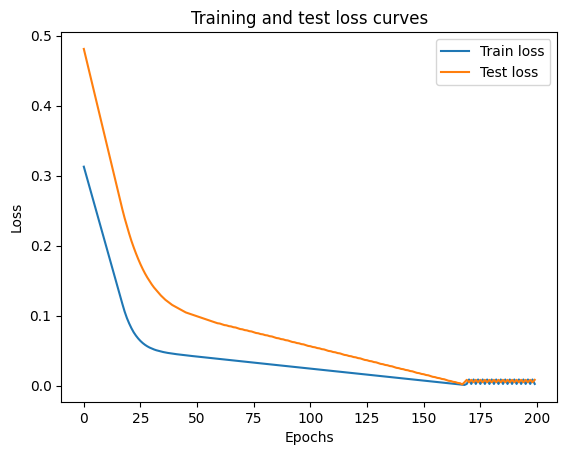

In [14]:
#Plot the loss curves
plt.plot(epoch_count,np.array(torch.tensor(loss_values).numpy()), label ="Train loss")
plt.plot(epoch_count,test_loss_values, label ="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

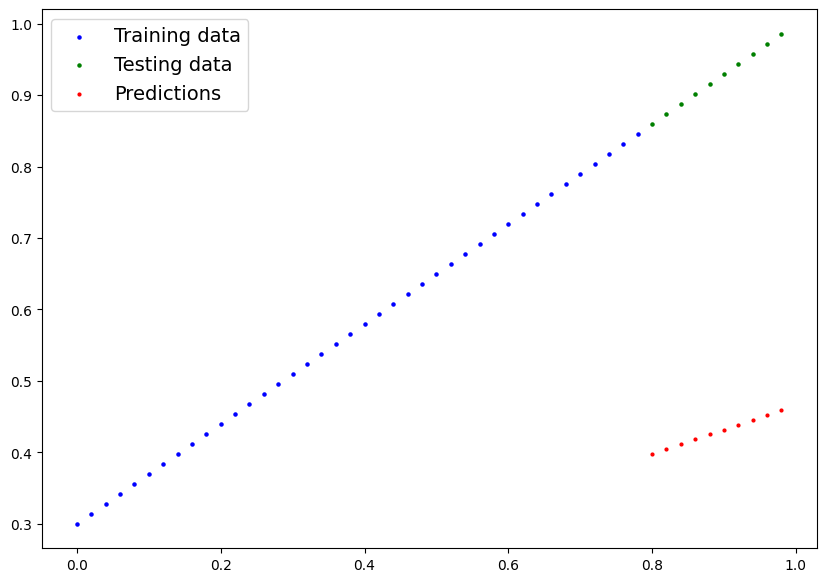

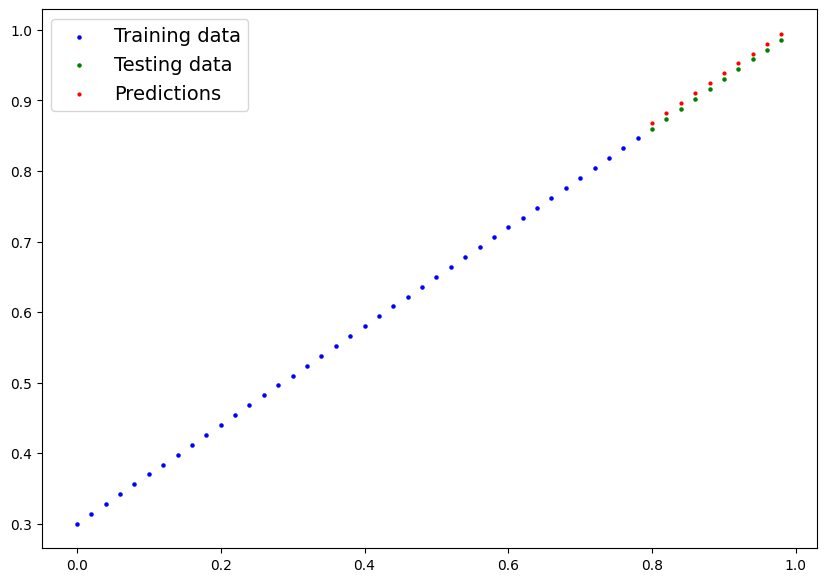

In [15]:
with torch.inference_mode():
        y_preds_new = model_0(X_test)
plot_predictions(predictions= y_preds)
plot_predictions(predictions= y_preds_new)

## 4. Saving and Loading a model

There are three main methos for saving and loading models in PyTorch.

1. `torch.save()` - allows you to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - Allows to load a model's saved state dictionary

### Saving a model in PyTorch



In [16]:
# Saving PyTorch model
from pathlib import Path
# 1. Create models directory
if not os.path.exists('models'):
    os.makedirs('models')
    
MODEL_PATH = Path("models")

# 2. Create model save path

MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3. Save the models state_dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH) # Can also just save the model



Saving model to: models\01_pytorch_workflow_model_0.pth


### Loading a PyTorch model

Since the model's `state_dict` was saved, a new instance of the model class will be created and the loaded data will be saved into that

In [17]:
# Create new model
loaded_model_0 = LinearRegressionModel()

#Check what is in it now
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [18]:
# Load the old model

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_0.state_dict()

C:\Users\dexti\AppData\Local\Temp\ipykernel_25648\3312267909.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH)

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

## 5. Putting it all together (Still linear regression)

### 5.0 Imports

In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
device = "cpu" if torch.cuda.is_available() else "cpu" # change first cpu to cuda, to use gpu

### 5.1 Data

In [20]:
# Create *known parameters
a = -3.4
b=7.1
c=5.2

# Create range of numbers

start = -10
end = 10
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = a*X+b
#y = a*X**2+b*X+c
X= X.to(device)
y = y.to(device)

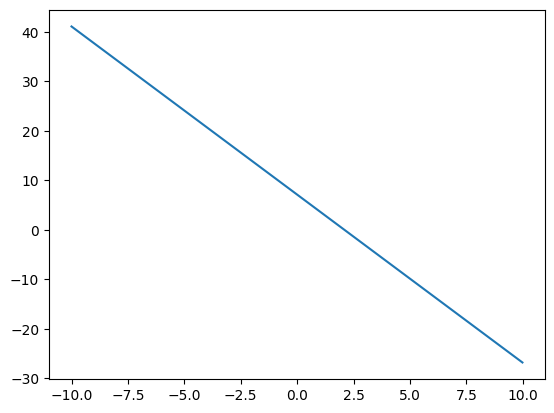

In [21]:
# Show the data

plt.plot(X,y)

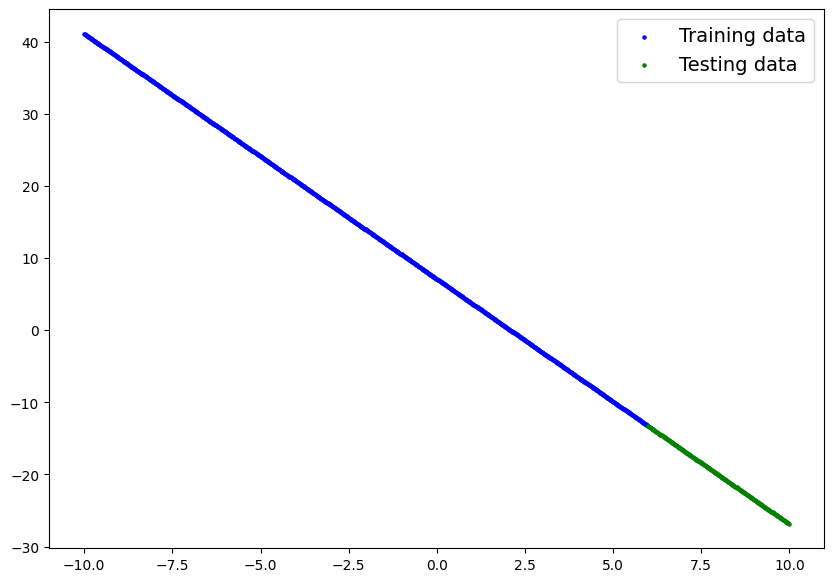

In [22]:
# Now to split it into training and test data:

split_position = int(0.8*len(X))

X_train = X[:split_position]
X_test = X[split_position:]
y_train = y[:split_position]
y_test = y[split_position:]
plot_predictions(train_data=X_train,train_labels=y_train, test_data=X_test, test_labels=y_test)

### 5.2 Building the model

In [23]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1) ##These represents layers, by adding more you get more layers, the in and out are neurons
        

        
        
    #Forward method to define the computation in the model
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x) #you times each layer together

In [24]:
# Create a random seed

torch.manual_seed(42)

# Create an instance of the model

model_1 = LinearRegressionModelV2()

#Check the parameters
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

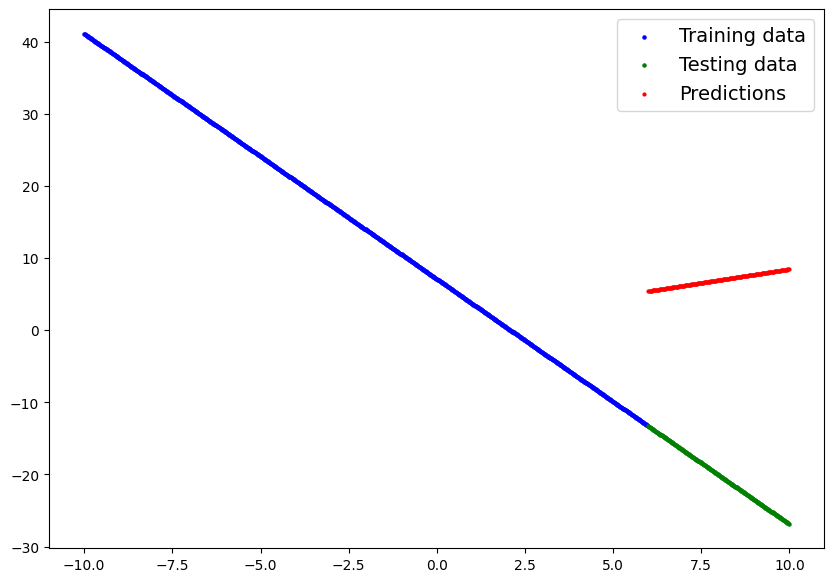

In [25]:
# Making Predictions

# Make preditions with model
y_preds = torch.tensor(1, device=device)
y_preds.device
with torch.inference_mode():
    y_preds = model_1(X_test)
    
X_test.shape,y_preds.shape
plot_predictions(train_data=X_train,train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds)

### 5.3 Training the data

In [26]:
# Setup a loss function (L1Loss = MAE (Mean absolute error))
loss_fn = nn.L1Loss()


# Setup an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), #Steepest gradient descent or stochastic gradient descent
                            lr=0.001) # learning rate

In [27]:
torch.manual_seed(42)
# An epoch is how many loops we want

epoch_count = []
loss_values = []
test_loss_values = []
epoch = 0
maxEpochs = 10000
loss = 10000
### Training
# step 0. Loop trough the data
for epoch in range(maxEpochs):
#while loss > 0.0005:
    #epoch += 1
    # Set the model to training mode
    model_1.train() #train mode in PyTorch sets all parameters that requires gradients to require gradients
    
    # 1. Forward propagation
    y_pred = model_1(X_train)
     
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    
    #3. Optimizer zero grad
    
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()
    
### Testing
    model_1.eval() #turns off gradient tracking
    
    with torch.inference_mode(): #turns off gradient tracking
        #1. Do the forward pass
        test_pred = model_1(X_test)
        
        #2. Calculate the loss
        test_loss = loss_fn(test_pred,y_test)
    
    #print out:
    
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_1.state_dict())
        print("\n")
    
    #MakeGIF(epoch, maxEpochs)
    
    if epoch > maxEpochs:
        break

#printout(epoch, loss)

Epoch: 0 | Loss: 19.875049591064453 | Test loss: 26.972270965576172
OrderedDict([('linear_layer.weight', tensor([[0.7604]])), ('linear_layer.bias', tensor([0.8304]))])


Epoch: 100 | Loss: 18.17668342590332 | Test loss: 23.744089126586914
OrderedDict([('linear_layer.weight', tensor([[0.3508]])), ('linear_layer.bias', tensor([0.8753]))])


Epoch: 200 | Loss: 16.50510025024414 | Test loss: 20.546300888061523
OrderedDict([('linear_layer.weight', tensor([[-0.0553]])), ('linear_layer.bias', tensor([0.9223]))])


Epoch: 300 | Loss: 14.870159149169922 | Test loss: 17.389951705932617
OrderedDict([('linear_layer.weight', tensor([[-0.4566]])), ('linear_layer.bias', tensor([0.9719]))])


Epoch: 400 | Loss: 13.287042617797852 | Test loss: 14.2925386428833
OrderedDict([('linear_layer.weight', tensor([[-0.8509]])), ('linear_layer.bias', tensor([1.0248]))])


Epoch: 500 | Loss: 11.779657363891602 | Test loss: 11.282404899597168
OrderedDict([('linear_layer.weight', tensor([[-1.2348]])), ('linear_layer

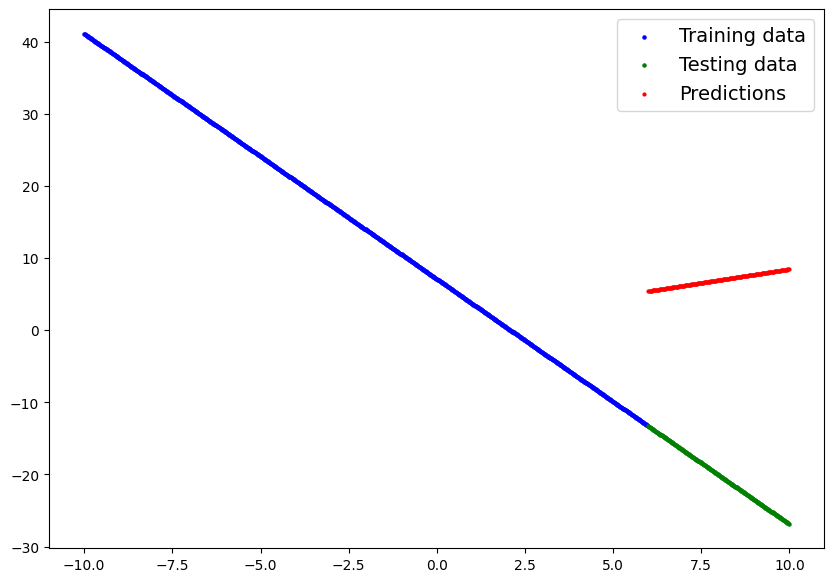

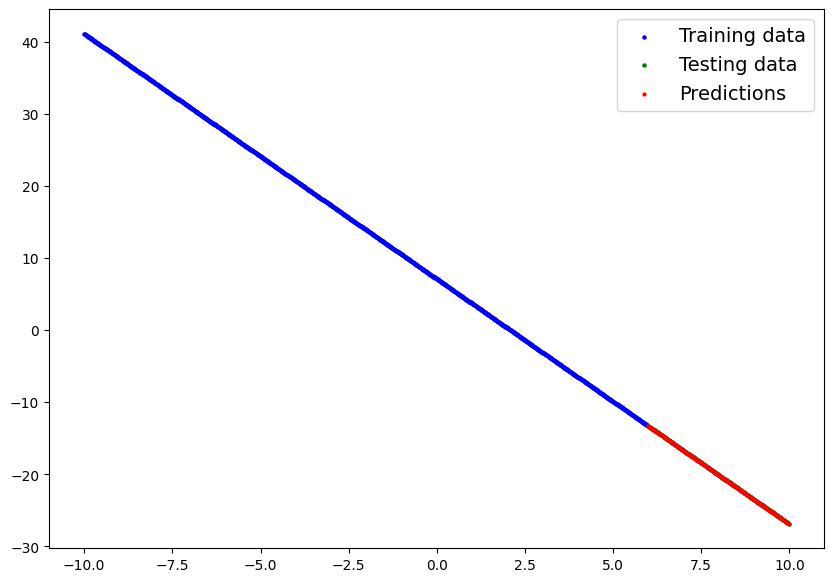

In [28]:
with torch.inference_mode():
    y_preds_new = model_1(X_test)
    
X_test.shape,y_preds.shape
plot_predictions(train_data=X_train,train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds)
plot_predictions(train_data=X_train,train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=y_preds_new)
